# Exploring the FORCE 2020 Well Log Challenge - Part 1
## Visualizing the well logs with matplotlib

**Brendon Hall, Enthought**

bhall@enthought.com

It's time for another facies classification challenge! [FORCE](https://www.npd.no/en/force/) and [XEEK](https://xeek.ai/) have teamed up to bring us the [2020 FORCE Machine Learning Contest](https://xeek.ai/challenges/force-well-logs/overview). Peter Borman and his colleagues have curated a set of 100+ well logs from the North Sea. In addition to the log curves, each well has interpreted lithofacies.  This is an awesome addition to the open data that is available for building tools for digital geoscience.  Machine learning based facies classification is a popular subject, and this is an exciting new benchmark dataset.

Since the [SEG Contest](https://github.com/seg/2016-ml-contest) in 2016, I've been impressed [how much innovation](https://www.linkedin.com/pulse/developments-machine-deep-learning-facies-brendon-hall) can come from an open dataset and a community interested in building new tools and techniques.  This time should be even better! The dataset is 10X the size and there are 4 years of new ideas to incorporate.  I thought it would be useful to create a few Jupyter notebooks that provide some ideas for getting started with this dataset. If you're new to Python and programming, this will help get you started exploring the data.  If you are more experienced, perhaps this will enable you to focus more on trying out different features or machine learning models.  In any case, you are welcome to use any or all of this code as you see fit.  If you have any suggestions or ideas for improvement, those are welcome as well.

This notebook will propose a colorbar for visualizing the lithofacies interpretations, and show how to use matplotlib to create a flexible log and lithofacies plot.  This is based on the log plot in my [facies classification tutorial](https://github.com/seg/2016-ml-contest/blob/master/Facies_classification.ipynb).  If you are brand new to Python and 'geocomputing', check out this [tutorial](https://www.youtube.com/watch?v=iIOMiN8Cacs&list=PLgLft9vxdduD8Zydz4dRJqIzCWDlPKITC&index=2&t=1241s) by Rob Leckenby to get started.  

Please get in touch if you have any questions!  You can also join in the conversation on [Software Underground's slack](https://softwareunderground.org/slack) in the **#force_2020_ml_contest** channel.

The well log data is licensed as [Norwegian License for Open Government Data (NLOD) 2.0](https://data.norge.no/nlod/en/2.0/).
The well log labels that are included are provided by FORCE 2020 Machine Learning Contest under [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/).

In [2]:
%matplotlib inline

import os.path

import numpy as np
import pandas as pd

import matplotlib.colors as colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets

pd.options.display.max_rows = 8

Let's start by loading up the training data.

You can get the dataset on the [contest website](https://xeek.ai/challenges/force-well-logs/data).  We'll only use the training dataset for this notebook.  If you have already downloaded the data, change the `local_train_csv` variable below to point to the file.  

If you don't have the data already, you can run the code below and download the data automatically from AWS-S3.  A local copy will be saved at the location specified by `local_train_csv`, so you won't have to download it every time.

Note, we're also making an effort to make the seismic 
data for the [fault competition](https://xeek.ai/challenges/force-seismic/overview) available
from S3, but through a simplified API. See this [repo](https://github.com/blasscoc/easy-as.git)
if you're also interested in the fault mapping competition.

In [3]:
# change this to the location of the training data on your disk if
# you have already downloaded it
local_train_csv = 'train.csv'

if not os.path.isfile(local_train_csv):
    # load from s3
    s3_train_csv = 's3://zarr-depot/wells/FORCE: Machine Predicted Lithology/train.csv'
    wells_df = pd.read_csv(s3_train_csv, sep=';')
    wells_df.to_csv(local_train_csv, index=False)
    
else:
    # load from disk
    wells_df = pd.read_csv(local_train_csv)

We'll need a list of all of the well names in the dataset.

In [4]:
wells_df

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.5280,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,...,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.6800,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,...,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.8320,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,...,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.9840,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,...,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170507,7/1-2 S,3169.4644,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.379244,NaN,NaN,...,28.024338,NaN,NaN,-0.007600,NaN,NaN,26.840818,NaN,65030,2.0
1170508,7/1-2 S,3169.6164,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.350248,NaN,NaN,...,28.091282,NaN,NaN,-0.018297,NaN,NaN,27.007942,NaN,65030,2.0
1170509,7/1-2 S,3169.7684,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.313779,NaN,NaN,...,28.019775,NaN,NaN,-0.011438,NaN,NaN,27.175179,NaN,65030,2.0
1170510,7/1-2 S,3169.9204,NaN,NaN,NaN,VESTLAND GP.,Bryne Fm.,8.294910,NaN,NaN,...,25.985943,NaN,NaN,-0.011398,NaN,NaN,27.342442,NaN,65030,2.0


In [5]:
well_names = wells_df['WELL'].unique()

The 12 facies labels in the csv have integer codes.  Let's add a couple of columns to make these codes easier for both humans and machines to understand.  We'll add a more descriptive label for the lithology and also an integer value (numbered 0-11) that will be used for visualization (and later, labels for supervised machine learning)

In [6]:
# map of lithology codes to description
lithology_keys = {30000: 'Sandstone',
                     65030: 'Sandstone/Shale',
                     65000: 'Shale',
                     80000: 'Marl',
                     74000: 'Dolomite',
                     70000: 'Limestone',
                     70032: 'Chalk',
                     88000: 'Halite',
                     86000: 'Anhydrite',
                     99000: 'Tuff',
                     90000: 'Coal',
                     93000: 'Basement'}
    
# map of lithology codes to integer label for ML
lithology_numbers = {30000: 0,
             65030: 1,
             65000: 2,
             80000: 3,
             74000: 4,
             70000: 5,
             70032: 6,
             88000: 7,
             86000: 8,
             99000: 9,
             90000: 10,
             93000: 11}
    
def map_lith_key(lith_map, row):
    
    lith_key = row['FORCE_2020_LITHOFACIES_LITHOLOGY']
    
    if lith_key in lith_map:
        return lith_map[lith_key]
    else:
        print('Warning: Key {} not found in map'.format(lith_key))
        return np.nan

wells_df['LITHOLOGY'] = wells_df.apply (lambda row: map_lith_key(lithology_keys, row), axis=1)
wells_df['LITH_LABEL'] = wells_df.apply (lambda row: map_lith_key(lithology_numbers, row), axis=1)

In [7]:
wells_df[['FORCE_2020_LITHOFACIES_LITHOLOGY', 'LITHOLOGY', 'LITH_LABEL']]

,FORCE_2020_LITHOFACIES_LITHOLOGY,LITHOLOGY,LITH_LABEL
0,65000,Shale,2
1,65000,Shale,2
2,65000,Shale,2
3,65000,Shale,2
...,...,...,...
1170507,65030,Sandstone/Shale,1
1170508,65030,Sandstone/Shale,1
1170509,65030,Sandstone/Shale,1
1170510,65030,Sandstone/Shale,1


Now let's set up a color map to make visualizing the facies with the well logs easier. This will also be useful when comparing machine learning results. This color scheme is loosely based on the one I [used before]().  Sandstone is yellow, Shale is green, and Sandstone-shale is somewhere in between. Carbonates are shades of blues, salts are shades of violet.  [Tuff](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/tuff) is lava red (of course), coal is black and basement is orange (because why not).

If you would like to choose other colors, here's a color picker widget that can help.  Click the arrows at the bottom of the color picker tool to change to hex notation.

In [ ]:
color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False
)

display(color_picker)

In [9]:
facies_color_map = { 'Sandstone': '#F4D03F',
                     'Sandstone/Shale': '#7ccc19',
                     'Shale': '#196F3D',
                     'Marl': '#160599',
                     'Dolomite': '#2756c4',
                     'Limestone': '#3891f0',
                     'Chalk': '#80d4ff',
                     'Halite': '#87039e',
                     'Anhydrite': '#ec90fc',
                     'Tuff': '#FF4500',
                     'Coal': '#000000',
                     'Basement': '#DC7633'}

# get a list of the color codes.
facies_colors = [facies_color_map[mykey] for mykey in facies_color_map.keys()]

Now define a function that creates a plot with log curves, as well as a lithofacies track.  This plot will be flexible, in that we can provide a list of curve mnemonics that we want to include in the plot.

In [10]:
def make_facies_log_plot(log_df, curves, facies_colors):
    
    #make sure logs are sorted by depth
    logs = log_df.sort_values(by='DEPTH_MD')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster=np.repeat(np.expand_dims(logs['LITH_LABEL'].values,1), 100, 1)
    
    num_curves = len(curves)
    f, ax = plt.subplots(nrows=1, ncols=num_curves+1, figsize=(num_curves*2, 12))
    
    for ic, col in enumerate(curves):
        
        # if the curve doesn't exist, make it zeros
        if np.all(np.isnan(logs[col])):
            curve = np.empty(logs[col].values.shape)
            curve[:] = np.nan
            
        else:
            curve = logs[col]
            
        ax[ic].plot(curve, logs['DEPTH_MD'])
        ax[ic].set_xlabel(col)
        ax[ic].set_yticklabels([]);

    # make the lithfacies column
    im=ax[num_curves].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=11)
    
    divider = make_axes_locatable(ax[num_curves])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((12*' ').join(['  SS', 'SS-Sh', 'Sh', 
                                ' Ml', 'Dm', 'LS', 'Chk ', 
                                '  Hl', 'Ann', 'Tuf', 'Coal', 'Bsmt']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[num_curves].set_xlabel('Facies')
    ax[num_curves].set_yticklabels([])
    ax[num_curves].set_xticklabels([])
    
    f.suptitle('Well: %s'%logs.iloc[0]['WELL'], fontsize=14,y=0.94)
    
    plt.show()

Let's try it out for sample well.  Include the standard 'triple combo' logs.

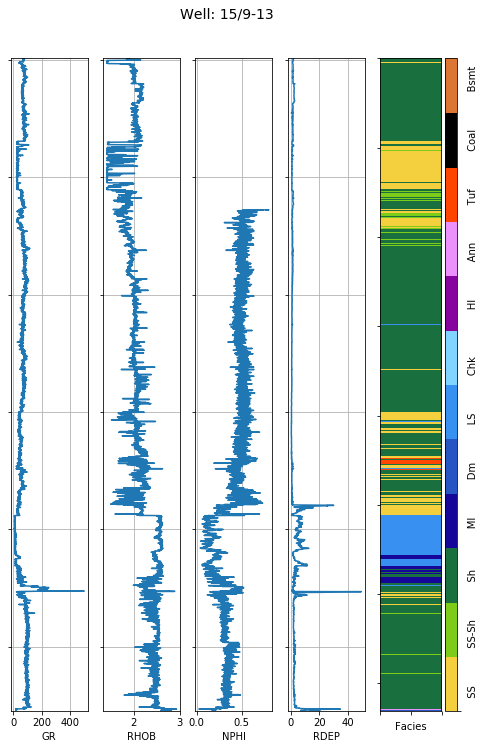

In [11]:
make_facies_log_plot(
    wells_df[wells_df['WELL'] == '15/9-13'],
    ['GR', 'RHOB', 'NPHI', 'RDEP'],
    facies_colors)

Now let's try it for all of the curves.  First, define a list with all of the curve names.

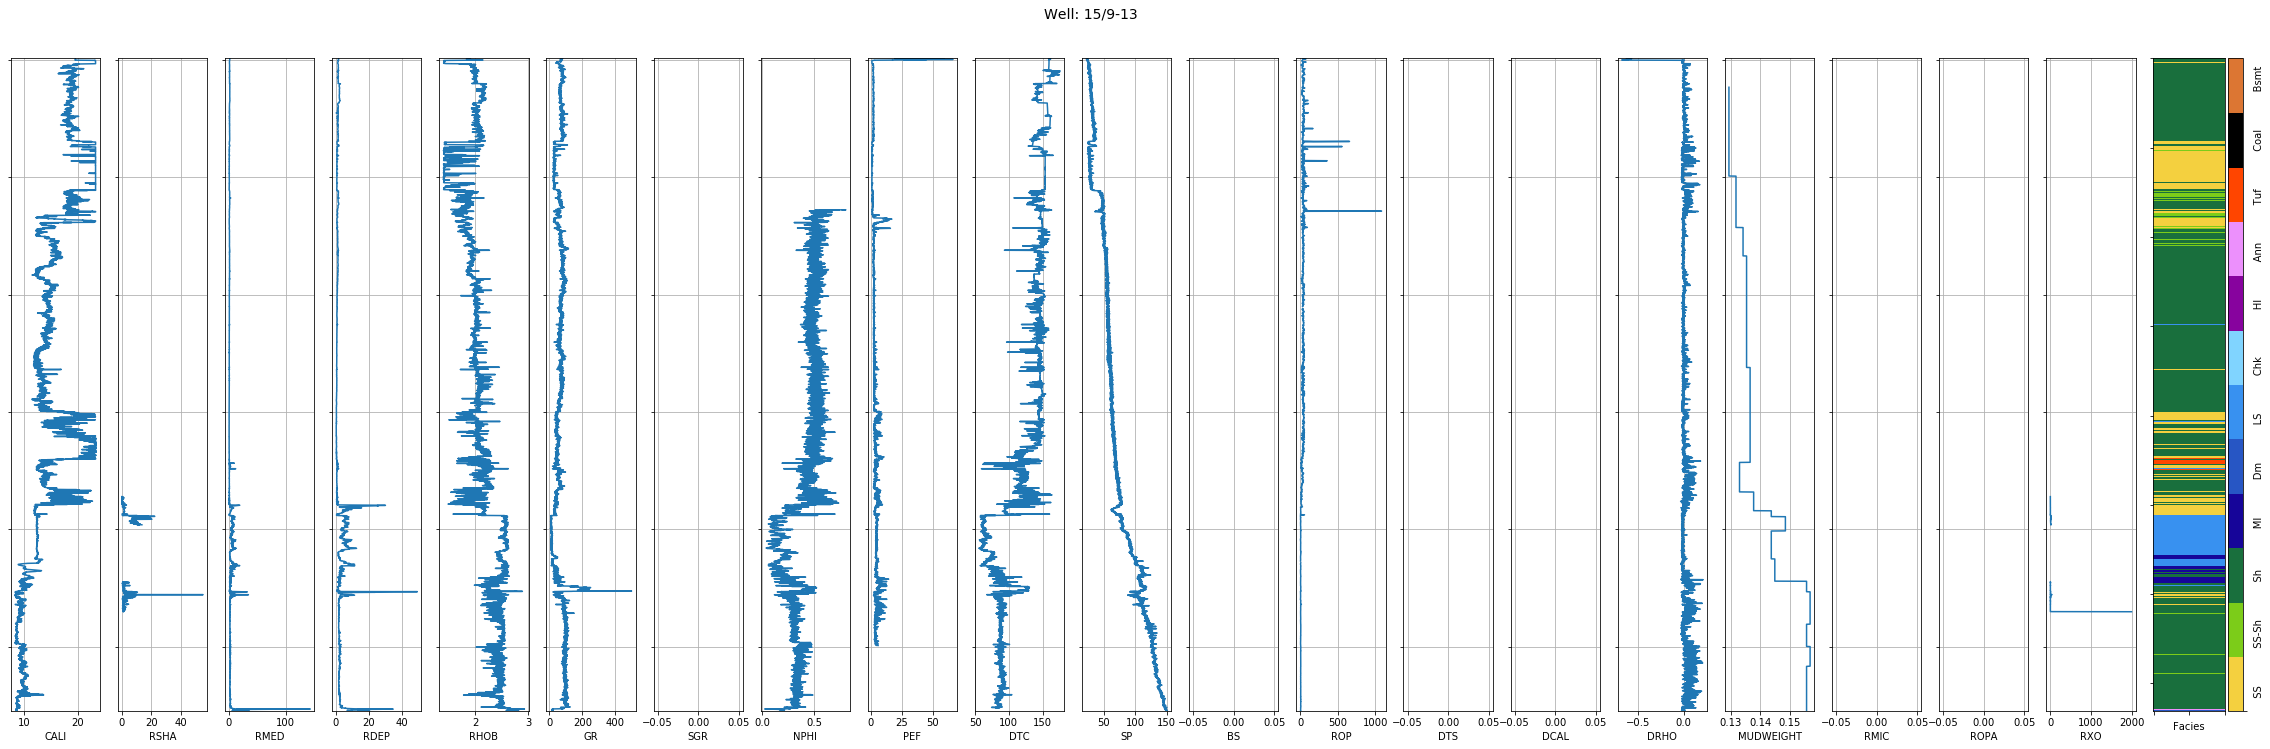

In [12]:
columns = ['CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR',
           'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO',
           'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO']

make_facies_log_plot(
    wells_df[wells_df['WELL'] == '15/9-13'],
    columns,
    facies_colors)

It's not very easy to read with this many curves, but it's quick and flexible and should be useful when trying new machine learning ideas.

It would be cool if the plot was easier to customize.  Let's try the `ipywidgets` library, which gives us some controls to change the parameters of the plot.  Here, we'll create a dropdown that let's us change the well being displayed.  We'll use a multi-select box to indicate which curves to include in the plot (all are selected by default). Hold shift, control (or command) while clicking to select multiple curve names.  Click the button to generate the plot based on your selection.

In [ ]:
plot_output = widgets.Output()

dropdown_well = widgets.Dropdown(options = wells_df['WELL'].unique(), description='Well:', value='15/9-13')

select_curves = widgets.SelectMultiple(
    options=columns,
    value=columns,
    #rows=10,
    description='Curves:',
    disabled=False
)

plot_button = widgets.Button(
    description='Show well plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to plot well.'
)
        
def on_button_clicked(b):
    plot_output.clear_output()
    with plot_output:
        make_facies_log_plot(
            wells_df[wells_df['WELL'] == dropdown_well.value],
            select_curves.value,
            facies_colors)
        
plot_button.on_click(on_button_clicked)

display(dropdown_well)
display(select_curves)
display(plot_button)
display(plot_output)

I hope that this gives you some helpful code for plotting well curves and lithology in the FORCE 2020 dataset.  Please feel free to use any or all of this code for your own work.  There are plenty of ways to visualize well logs in Python.  Ashley Russell has a great [tutorial](https://youtu.be/ud4EZiNpblM) on how to build interactive well logs plots in Jupyter. 

This notebook is open source content. Text is CC-BY-4.0, code is [Apache 2.0](https://www.apache.org/licenses/LICENSE-2.0).

### References

Bormann P., Aursand P., Dilib F., Dischington P., Manral S. (2020) 2020 FORCE Machine Learning Contest. https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition